In [93]:
import matplotlib.pyplot as plt
from stompy import utils
import xarray as xr
import pandas as pd
from shapely import wkt
from stompy import xr_utils, xr_transect
from matplotlib import collections
import stompy.model.schism.schism_model as sch
import peschism
import numpy as np
import os
%matplotlib notebook

In [94]:
run_dirs=['data_schmouth_v032']

In [95]:
run_dir=run_dirs[0]
model=peschism.PescaSchism.load(run_dir)

In [96]:
model.set_grid_and_features() # to get the gazetteer

In [97]:
ms=model.map_output(4) 

<IPython.core.display.Javascript object>


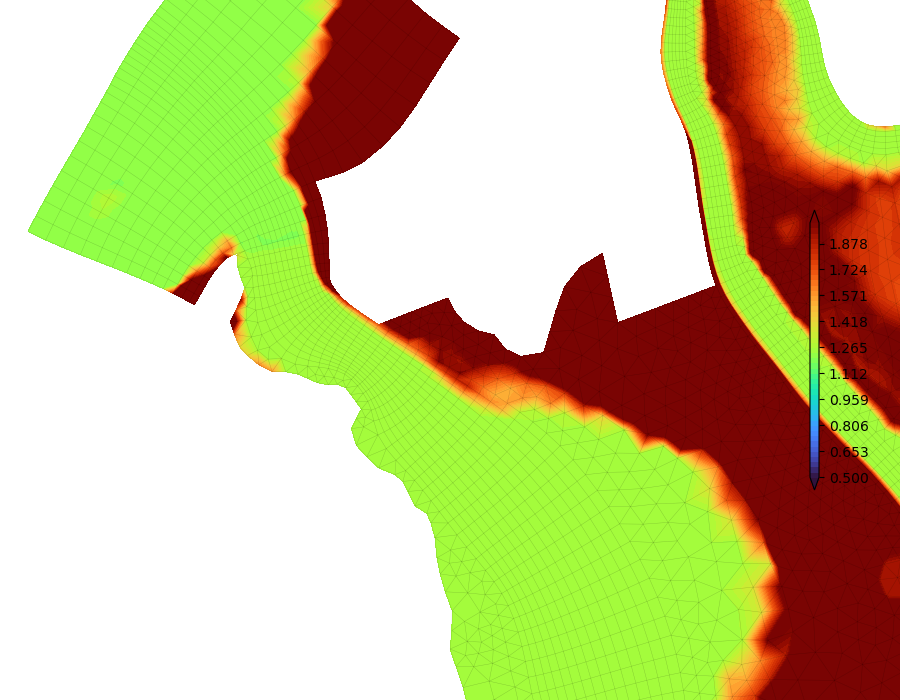

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [98]:
fig,ax=plt.subplots(figsize=(9,7))

ti=47
ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
cset=ms.grid.contourf_node_values(ms.elev.isel(time=ti).values,
                                  np.linspace(0.5,2.0,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))

In [99]:
lsc=model.read_vgrid_in()

ivcor=1
nvrt=80


<IPython.core.display.Javascript object>


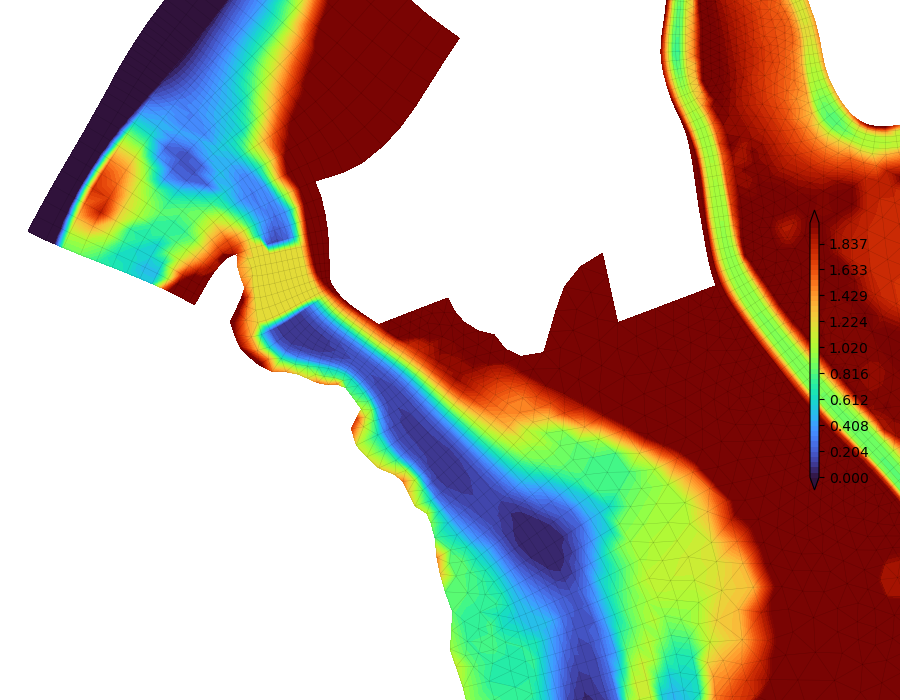

(551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551)

In [101]:
fig,ax=plt.subplots(figsize=(9,7))

ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
ti=9

dry=ms['wetdry_node'].isel(time=ti).values==1
bed_ix=(np.arange(ms.grid.Nnodes()),lsc['k0'])

z_bed=ms['zcor'].isel(time=9).values[bed_ix]
#z_bed=z_cor[np.arange(z_cor.shape[0]),lsc['k0']]
z_bed=np.where(dry,ms.grid.nodes['node_z_bed'],z_bed)
cset=ms.grid.contourf_node_values(z_bed,
                                  np.linspace(0.0,2.0,50),extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)
ax.axis((551946.6884960784, 552446.2403808217, 4124412.8287927504, 4124801.369147551))


<IPython.core.display.Javascript object>


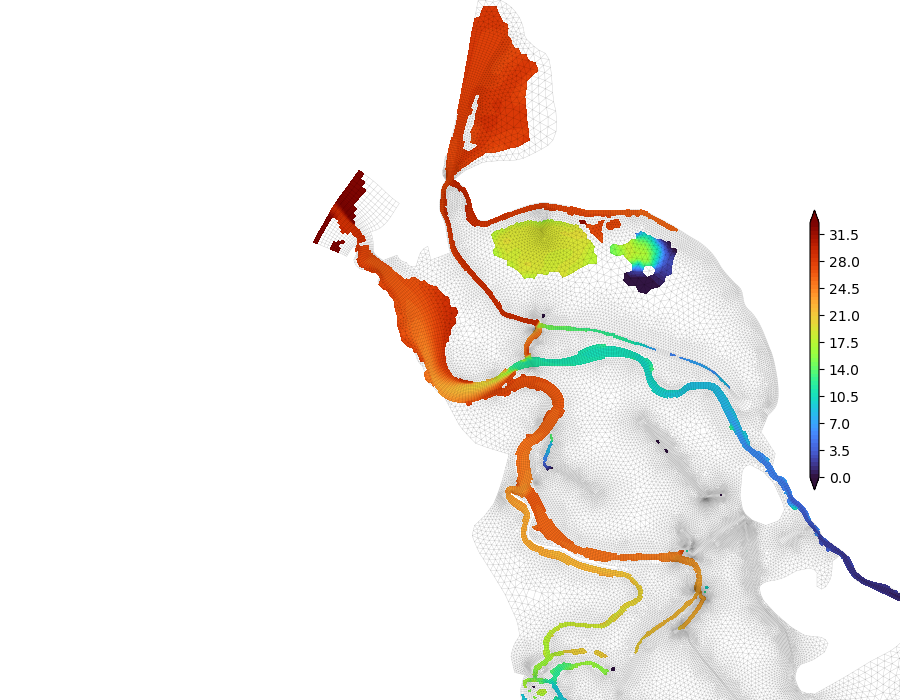

In [122]:
# Surface salinity:
fig,ax=plt.subplots(figsize=(9,7))

ti=8
ms.grid.plot_edges(color='k',lw=0.3,alpha=0.2)
wet_cell=ms.wetdry_elem.isel(time=ti).values<0.5

s_top=ms.salt.isel(time=ti,nSCHISM_vgrid_layers=-1).values
s_bed=ms.salt.isel(time=ti).values[bed_ix]
#data=s_bed-s_top ; V=np.linspace(0,10,21)
data=s_top ; V=np.linspace(0,33,67)

cset=ms.grid.contourf_node_values(data,V,
                                  tri_kwargs=dict(cell_mask=wet_cell),
                                  extend='both',cmap='turbo')
ax.axis('off')
ax.set_position([0,0,1,1])
ax.axis('tight')
ax.axis('equal')
cax=fig.add_axes([0.9,0.3,0.01,0.4])
plt.colorbar(cset,cax=cax)

In [103]:
# Getting a transect out.
# station output from schism has static x,y,z
# Would like to have a copy of the station data
# that splits z into a layer dimension.
# To keep it general (at the expense of memory),
# can treat z as completely independent for each
# x,y (but constant in time).

thalweg=model.get_geometry(name='thalweg_pesc')
nodes=ms.grid.select_edges_by_polyline(thalweg,return_nodes=True,boundary=False)

tran=ms.isel(nSCHISM_hgrid_node=nodes)
tran2=tran.rename(nSCHISM_hgrid_node='sample',zcor='z_int',nSCHISM_vgrid_layers='layer')
tran2['x_sample']=('sample',), ms.grid.nodes['x'][nodes,0]
tran2['y_sample']=('sample',), ms.grid.nodes['x'][nodes,1]

tran2['node']=('sample',),nodes
valid=np.ones((tran2.dims['sample'],tran2.dims['layer']), np.bool8)
k=np.arange(tran2.dims['layer'])
valid[ k[None,:] < lsc['k0'][nodes,None]]=False
tran2['valid']=('sample','layer'),valid
xr_transect.get_d_sample(tran2)
tran2

INFO:multi_ugrid:Dropping wetdry_elem because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping wetdry_side because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping bed_thickness because it has unselected partitioned dimensions


<xarray.Dataset>
Dimensions:            (layer: 80, sample: 244, time: 48, two: 2)
Coordinates:
  * time               (time) datetime64[ns] 2016-06-15T01:00:00 ... 2016-06-17
Dimensions without coordinates: layer, sample, two
Data variables:
    wetdry_node        (sample, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    z_int              (sample, time, layer) float32 0.0 0.0 0.0 ... 1.247 1.264
    elev               (sample, time) float32 1.682 1.819 1.855 ... 1.264 1.264
    dahv               (sample, time, two) float32 0.02574 -0.0502 ... 0.003614
    temp               (sample, time, layer) float32 15.0 15.0 ... 17.52 17.53
    salt               (sample, time, layer) float32 33.0 33.0 ... 5.647 5.607
    diffusivity        (sample, time, layer) float32 2.892e-08 ... 1.271e-08
    hvel               (sample, time, layer, two) float32 0.0 0.0 ... 0.02295
    SED_depth_change   (sample, time) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SED_bed_stress     (sample, time) float32 3.847e-05 5.057e-05 ... 4.267e-05
    SED_bed_roughness  (sample, time) float32 0.6061 0.6061 ... 0.335 0.335
    SED_TSC            (sample, time, layer) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    time_s             (time) float32 5.22e+05 5.256e+05 ... 6.876e+05 6.912e+05
    x_sample           (sample) float64 5.52e+05 5.52e+05 ... 5.531e+05
    y_sample           (sample) float64 4.125e+06 4.125e+06 ... 4.124e+06
    node               (sample) int32 43893 43892 43893 ... 14739 14747 14755
    valid              (sample, layer) bool False False False ... True True True
    d_sample           (sample) float64 0.0 3.581 7.161 ... 1.569e+03 1.576e+03

<IPython.core.display.Javascript object>


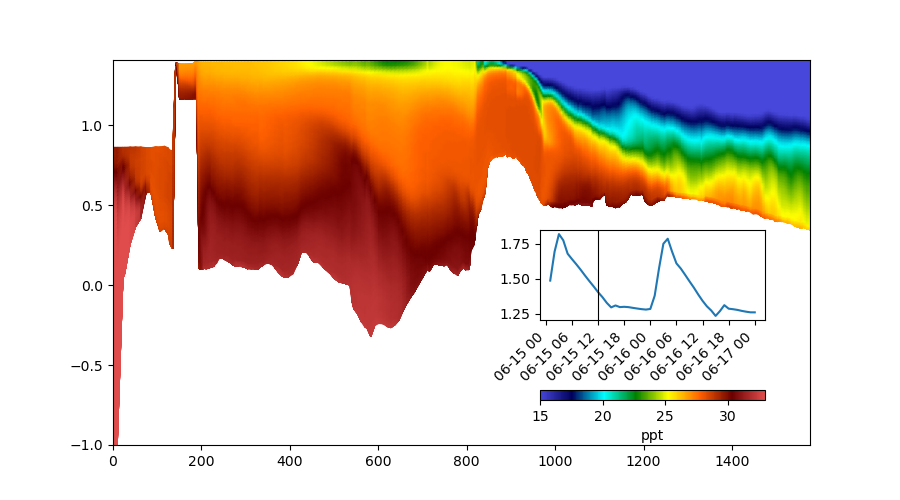

In [129]:
fig,ax=plt.subplots(figsize=(9.,5))
cax=fig.add_axes([0.6,0.2,0.25,0.02])
tax=fig.add_axes([0.6,0.36,0.25,0.18])
tax.plot(tran2.time,tran2.z_int.isel(sample=150,layer=-1))
plt.setp(tax.get_xticklabels(),rotation=45,ha='right')

import stompy.plot.cmap as scmap
cmap=scmap.load_gradient('hot_desaturated.cpt')

#for ti in range(tran2.dims['time']):
for ti in [11]: # [37]:
    ax.cla()
    x,z=xr.broadcast(tran2.d_sample,tran2.z_int.isel(time=ti))
    del tax.lines[1:]
    tax.axvline(tran2.time.values[ti],color='k',lw=0.8)
    z=z.values
    z_bed0=z[np.arange(z.shape[0]),lsc['k0'][tran2.node.values] ]
    # Can't cleanly mask out quadmesh below the bed, but we can collapse
    # z.
    valid=tran2.valid.values
    zval=np.where(valid,z,z_bed0[:,None])
    #qm=collections.QuadMesh(x.shape[1]-1,x.shape[0]-1,
    #                        np.c_[x.values.ravel(),zval.ravel()],
    #                        edgecolor='k',lw=0.2,alpha=0.3,zorder=3,facecolor='none')
    #ax.add_collection(qm)
    coll=ax.pcolormesh(x,zval,tran2['salt'].isel(time=ti).values,cmap=cmap,shading='gouraud')
    coll.set_clim([15,33])    
    coll.set_edgecolor('k')
    coll.set_lw(0.1)
    cax.cla()
    plt.colorbar(coll,cax=cax,orientation='horizontal',label='ppt')
    #fig.canvas.draw()
    #plt.pause(0.50)


In [11]:
# Select lateral line
# across=wkt.loads("""LineString (552277.98 4124323.4863, 552341.77 4124340.748, 552356.157 4124342.6248)
# """)

<IPython.core.display.Javascript object>


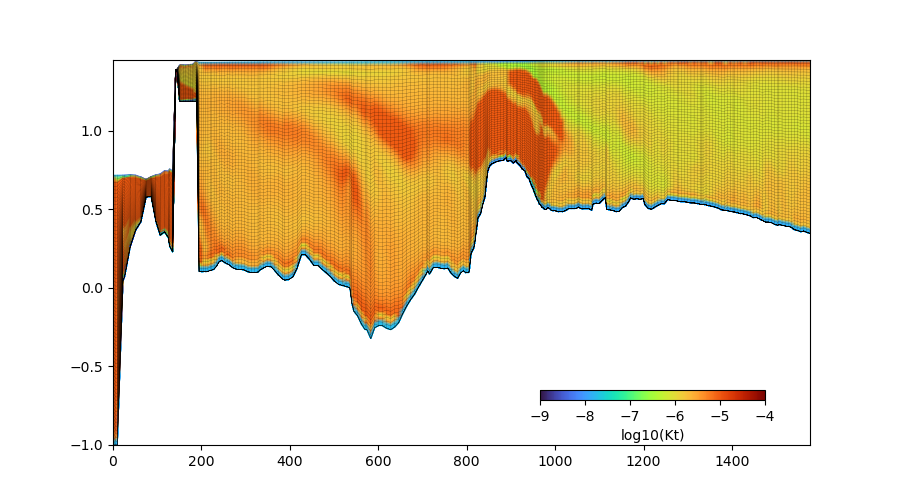

In [105]:
fig,ax=plt.subplots(figsize=(9.,5))
cax=fig.add_axes([0.6,0.2,0.25,0.02])

#for ti in range(tran2.dims['time']):
for ti in [10]:
    ax.cla()
    x,z=xr.broadcast(tran2.d_sample,tran2.z_int.isel(time=ti))
    z=z.values
    z_bed0=z[np.arange(z.shape[0]),lsc['k0'][tran2.node.values] ]
    # Can't cleanly mask out quadmesh below the bed, but we can collapse
    # z.
    valid=tran2.valid.values
    zval=np.where(valid,z,z_bed0[:,None])
    qm=collections.QuadMesh(x.shape[1]-1,x.shape[0]-1,
                            np.c_[x.values.ravel(),zval.ravel()],
                            edgecolor='k',lw=0.2,alpha=0.3,zorder=3,facecolor='none')
    ax.add_collection(qm)
    #scal='salt' ; clim=[0,33]
    clim=[-9,-4]
    scal=np.log10(tran2['diffusivity'].isel(time=ti).values.clip(10**clim[0]))
    coll=ax.pcolormesh(x,zval,scal,cmap='turbo',shading='gouraud')
    coll.set_clim(clim)    
    coll.set_edgecolor('k')
    coll.set_lw(0.1)
    cax.cla()
    plt.colorbar(coll,cax=cax,orientation='horizontal',label='log10(Kt)')
    fig.canvas.draw()
    plt.pause(0.10)


In [58]:
diffs=tran2.diffusivity.values
(diffs!=0.0).sum()

0

<IPython.core.display.Javascript object>


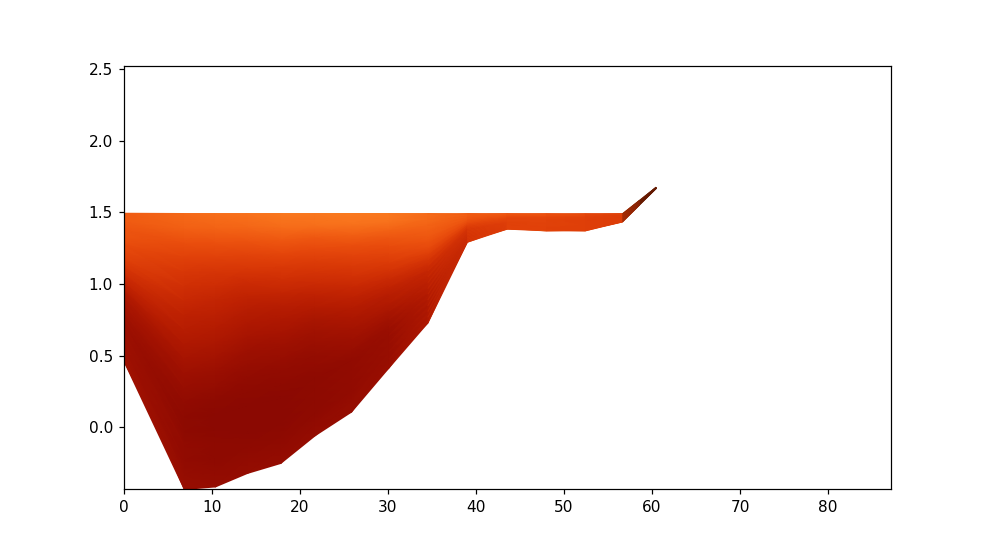

In [102]:
from stompy import xr_transect
fig,ax=plt.subplots(figsize=(9.,5))

for ti in range(tran3.dims['time']):
    ax.cla()
    tran3t=tran3.isel(time=ti)
    x,z,s,wetdry=xr.broadcast(tran3t.d_sample,tran3t.z_int,
                              tran3t['salt'],
                              tran3t['wetdry_node'])
    # Not quite right with the flat shading, but it lets us see the
    # mesh
    s=s.values
    s[wetdry.values==1]=np.nan
    
    coll=ax.pcolormesh(x,z,s,cmap='turbo',shading='gouraud')
    coll.set_clim([0,33])    
    coll.set_edgecolor('k')
    coll.set_lw(0.1)
    fig.canvas.draw()
    plt.pause(0.10)
    break

In [10]:
ds=model.station_output()
qcm=model.prep_qcm_data()
sub_qcm=qcm.isel(time=(qcm.time>=ds.time.values[0])&(qcm.time<=ds.time.values[-1]))

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [11]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"
# Shift to NAVD88 adjusted data:
fn=os.path.join(bml_data_dir,
                '../water_level/elevationNAVD88',
                '2016_NCK_wll_referenced_concat.csv')
df=pd.read_csv(fn)
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
df['depth m']=df['NAVD88']
nck_wll=df.set_index('time')
observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')

<IPython.core.display.Javascript object>


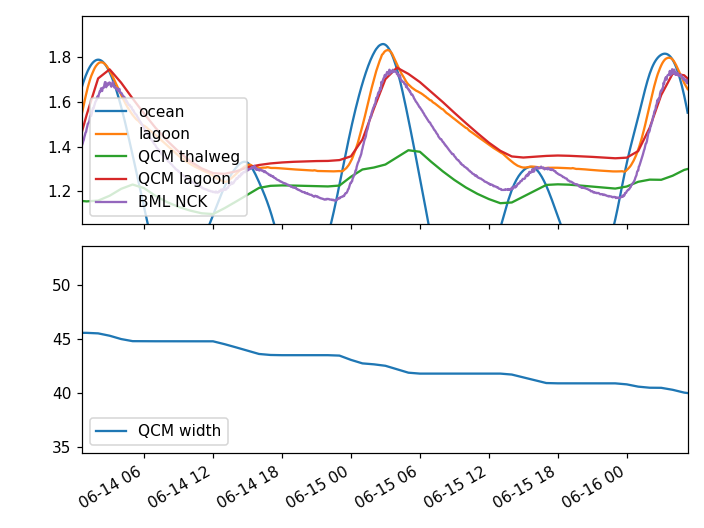

In [13]:
# Find a spot in the lagoon, and a spot near the ocean
xy_ocean=[552041.12, 4124763.48]
xy_lagoon=[552277.89, 4124400.70]

sta_ocean=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_ocean))
sta_lagoon=np.argmin( utils.dist(np.c_[ds.x, ds.y], xy_lagoon))

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].plot(ds.time,ds['elev'].isel(station=sta_ocean),label='ocean')
axs[0].plot(ds.time,ds['elev'].isel(station=sta_lagoon),label='lagoon')

# Needs to be updated
#morph_nodes=[model.grid.cell_to_nodes(c) for c in model.morph_elts]
#morph_nodes=np.unique(np.concatenate(morph_nodes))
#morph_values=ms['zcor'].isel(nSCHISM_hgrid_node=morph_nodes,nSCHISM_vgrid_layers=0).values

# Note that zcor is not updated for dry nodes. Mask those out with nan
#dry=ms['wetdry_node'].isel(nSCHISM_hgrid_node=morph_nodes).values==1
#morph_values[dry] *= np.nan
#axs[0].plot(ms.time.values, morph_values.T, lw=0.5,color='k',alpha=0.4)

axs[0].plot(sub_qcm.time, sub_qcm['z_thalweg'],label='QCM thalweg')
axs[0].plot(sub_qcm.time, sub_qcm['z_lagoon'],label='QCM lagoon')
axs[0].plot(observed.time,observed,label='BML NCK')

axs[1].plot(sub_qcm.time, sub_qcm['w_inlet'],label='QCM width')
axs[1].legend(loc='lower left')

axs[0].legend(loc='lower left')
axs[0].axis((16965.746119791667,
 16966.941029905913,
 1.0646761950992403,
 1.3233571120670864))
fig.autofmt_xdate()
fig.tight_layout()